In [20]:
from cosmogrb.universe.survey import Survey
import zusammen
import arviz
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel
import cmdstanpy
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
ds = zusammen.DataSet.from_hdf5_file('data/sgrb.h5')

In [22]:
data = ds.to_stan_dict()
#N_gen_spectra = 100
#model_energy = np.logspace(0,5,N_gen_spectra)
#data['N_gen_spectra'] = N_gen_spectra
#data['model_energy'] = model_energy

warmup = 500
samps = 250

total = warmup + samps

chains = 4

In [23]:
cmdstanpy.utils.jsondump("test_data.json", data)

In [25]:
model = CmdStanModel(stan_file="stan/cor_test.stan", 
                     cpp_options={'STAN_THREADS': 'TRUE'})

2020-06-23 16:42:35 Francescas-MacBook-Pro.local cmdstanpy[39171] INFO compiling stan program, exe file: /Users/fran/projects/zusammen/examples/stan/cor_test
2020-06-23 16:42:35 Francescas-MacBook-Pro.local cmdstanpy[39171] INFO compiler options: stanc_options={'include_paths': ['/Users/fran/projects/zusammen/examples/stan']}, cpp_options={'STAN_THREADS': 'TRUE'}
2020-06-23 16:43:01 Francescas-MacBook-Pro.local cmdstanpy[39171] INFO compiled model file: /Users/fran/projects/zusammen/examples/stan/cor_test


In [26]:
os.environ["STAN_NUM_THREADS"] = "4"

fit = model.sample(
    data=data,
    cores=4,
    iter_warmup=warmup,
    iter_sampling=samps,
    chains=chains,
    max_treedepth=10,
    show_progress="notebook",
    seed=16574)

av = arviz.from_cmdstanpy(fit)

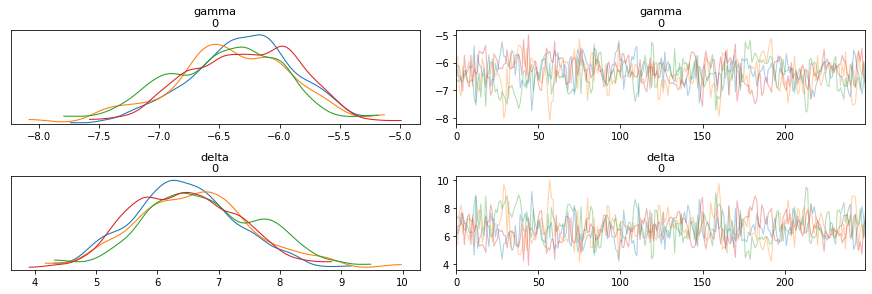

In [27]:
arviz.plot_trace(av, var_names=["gamma", "delta"]);

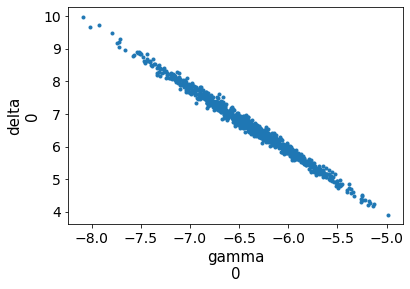

In [28]:
arviz.plot_pair(av, var_names=["gamma", "delta"], divergences=True);

In [29]:
av.posterior

<xarray.Dataset>
Dimensions:                (alpha_dim_0: 9, chain: 4, delta_dim_0: 1, draw: 250, gamma_dim_0: 1, log_energy_flux_dim_0: 9, log_epeak_dim_0: 9)
Coordinates:
  * chain                  (chain) int64 0 1 2 3
  * draw                   (draw) int64 0 1 2 3 4 5 ... 244 245 246 247 248 249
  * gamma_dim_0            (gamma_dim_0) int64 0
  * delta_dim_0            (delta_dim_0) int64 0
  * alpha_dim_0            (alpha_dim_0) int64 0 1 2 3 4 5 6 7 8
  * log_epeak_dim_0        (log_epeak_dim_0) int64 0 1 2 3 4 5 6 7 8
  * log_energy_flux_dim_0  (log_energy_flux_dim_0) int64 0 1 2 3 4 5 6 7 8
Data variables:
    gamma                  (chain, draw, gamma_dim_0) float64 -6.105 ... -6.736
    delta                  (chain, draw, delta_dim_0) float64 6.201 ... 7.156
    alpha                  (chain, draw, alpha_dim_0) float64 -0.9397 ... -1.454
    log_epeak              (chain, draw, log_epeak_dim_0) float64 1.944 ... 2.148
    log_energy_flux        (chain, draw, log_energy_flux_dim_0) float64 -5.668 ... -7.314
Attributes:
    created_at:                 2020-06-23T17:04:11.778704
    arviz_version:              0.8.3
    inference_library:          cmdstanpy
    inference_library_version:  0.9.5

AttributeError: 'Dataset' object has no attribute 'normed_epeak'

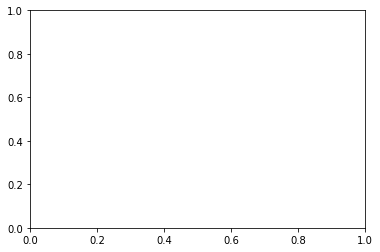

In [30]:
fig, ax = plt.subplots()

for i in range(9):

    ax.scatter(np.concatenate(av.posterior.normed_epeak[:,:,i]), 
               np.concatenate(av.posterior.raw_ef[:,:,i]), s=1)
    
    
xx = np.linspace(0,3,50)


#ax.plot(xx+2, 1.2 * (xx+2) - 10.6)



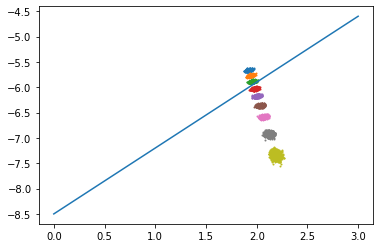

In [31]:
fig, ax = plt.subplots()

for i in range(9):

    ax.scatter(np.concatenate(av.posterior.log_epeak[:,:,i]),
               np.concatenate(av.posterior.log_energy_flux[:,:,i]), s=1)
    

xx = np.linspace(0,3,50)

ax.plot(xx, 1.3*xx - 8.5)

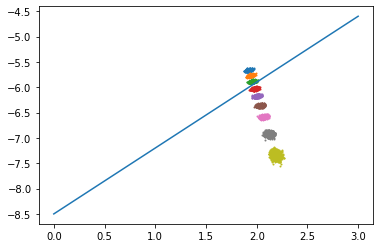

In [32]:
fig, ax = plt.subplots()

for i in range(9):

    ax.scatter(np.concatenate(av.posterior.log_epeak[:,:,i]),
               np.concatenate(av.posterior.log_energy_flux[:,:,i]), s=1)
    
    
xx = np.linspace(0,3,50)

ax.plot(xx, 1.3*xx - 8.5)

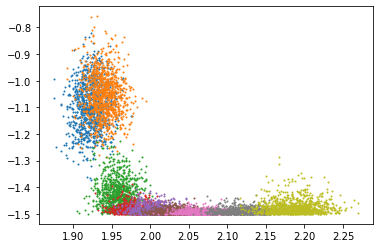

In [33]:
fig, ax = plt.subplots()

for i in range(9):

    ax.scatter(np.concatenate(av.posterior.log_epeak[:,:,i]),np.concatenate(av.posterior.alpha[:,:,i]), s=1)
    
    
# xx = np.linspace(0,3,50)


# ax.plot(xx, 1.46 * xx - 8.7)

# ax.plot(xx, 1.5 * xx - 8.7)

[Text(0, 0.5, 'alpha'), Text(0.5, 0, 'log energy flux')]

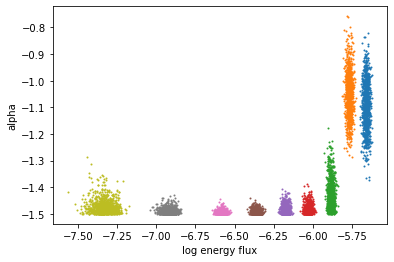

In [34]:
fig, ax = plt.subplots()

for i in range(9):

    ax.scatter(np.concatenate(av.posterior.log_energy_flux[:,:,i]),np.concatenate(av.posterior.alpha[:,:,i]), s=1)
    
    
# xx = np.linspace(0,3,50)


# ax.plot(xx, 1.46 * xx - 8.7)

# ax.plot(xx, 1.5 * xx - 8.7)


ax.set(xlabel="log energy flux", ylabel="alpha")

# Debugging

In [ ]:
import cosmogrb

In [ ]:
grb_reload = cosmogrb.GRBSave.from_file('data/sgrb.h5')